<a href="https://colab.research.google.com/github/thescalableguy/Machine_Learning_Notebooks/blob/main/Machine_Unlearning_Data_Obfuscation_MLP_CapstoneProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Unlearning with Data Obfuscation

```
Problem Statement: MLP on MNIST Dataset
```

**Model Selection:**
*   Dataset: MNIST is simple (28x28 grayscale images) → ideal for MLP.
*   Task: Multi-class classification (10 digits)
*   Why MLP: MLP is a good starting point for tabular/flat pixel data (784-dim input vector).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
import os

# Device Configuration

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Configuration

In [ ]:
NUM_CLASSES = 10
INPUT_SIZE = 28 * 28 # MNIST image dimensions
HIDDEN_SIZE = 128
LEARNING_RATE = 0.001
BATCH_SIZE = 64
NUM_EPOCHS = 5 # Number of times to iterate over the entire dataset

# Model Architecture

```
Input (784) → Dense(256) → ReLU → Dense(128) → ReLU → Dense(10) → Softmax
```

*   Linear layers with ReLU activation
*   Final layer with 10 output neurons (one per class)




In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleMLP, self).__init__()
        self.flatten = nn.Flatten() # Flattens the 28x28 image
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

In [ ]:
# --- Instantiate the Model ---
model = SimpleMLP(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES).to(device)
print("Model Architecture:")
print(model)

Model Architecture:
SimpleMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=128, out_features=10, bias=True)
)


# Data Pre-Processing

*   Flattened images from 28x28 to 784
*   Normalized pixel values from [0–255] → [0–1]


In [ ]:
print("\nLoading MNIST data...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Mean and std dev for MNIST
])


Loading MNIST data...


In [ ]:
# Download and load the training data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Download and load the test data
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False) # No need to shuffle test data

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.73MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.73MB/s]

Training samples: 60000
Test samples: 10000
Number of training batches: 938
Number of test batches: 157


# Loss Function and Optimizer
  

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Adam optimizer

print(f"\nOptimizer: Adam, Learning Rate: {LEARNING_RATE}")
print(f"Loss Function: CrossEntropyLoss")


Optimizer: Adam, Learning Rate: 0.001
Loss Function: CrossEntropyLoss


# Model Training

In [ ]:
print(f"\nStarting Training for {NUM_EPOCHS} epochs...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train() # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # --- Forward Pass ---
        outputs = model(images)
        loss = criterion(outputs, labels)

        # --- Backward Pass and Optimize ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # --- Track Statistics ---
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Calculate epoch statistics
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    print(f'--- Epoch [{epoch+1}/{NUM_EPOCHS}] Completed ---')
    print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}')


training_time = time.time() - start_time
print(f"\nTraining finished in {training_time:.2f} seconds.")

# Save the trained model
torch.save(model.state_dict(), 'mnist_mlp_pytorch.pth')
print("Trained model state dictionary saved to mnist_mlp_pytorch.pth")


Starting Training for 5 epochs...
--- Epoch [1/5] Completed ---
Training Loss: 0.2612, Training Accuracy: 0.9238
--- Epoch [2/5] Completed ---
Training Loss: 0.1164, Training Accuracy: 0.9647
--- Epoch [3/5] Completed ---
Training Loss: 0.0813, Training Accuracy: 0.9756
--- Epoch [4/5] Completed ---
Training Loss: 0.0620, Training Accuracy: 0.9809
--- Epoch [5/5] Completed ---
Training Loss: 0.0498, Training Accuracy: 0.9839

Training finished in 84.89 seconds.
Trained model state dictionary saved to mnist_mlp_pytorch.pth


# Model Evaluation


--- Evaluating Model on Test Set ---
Accuracy of the network on the 10000 test images: 97.59 %

--- Detailed Evaluation Metrics ---
Overall Test Accuracy (sklearn): 0.9759

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.98      0.99      0.99      1135
           2       0.95      0.99      0.97      1032
           3       0.99      0.96      0.97      1010
           4       0.99      0.96      0.97       982
           5       0.97      0.98      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.99      0.97      0.98       974
           9       0.95      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



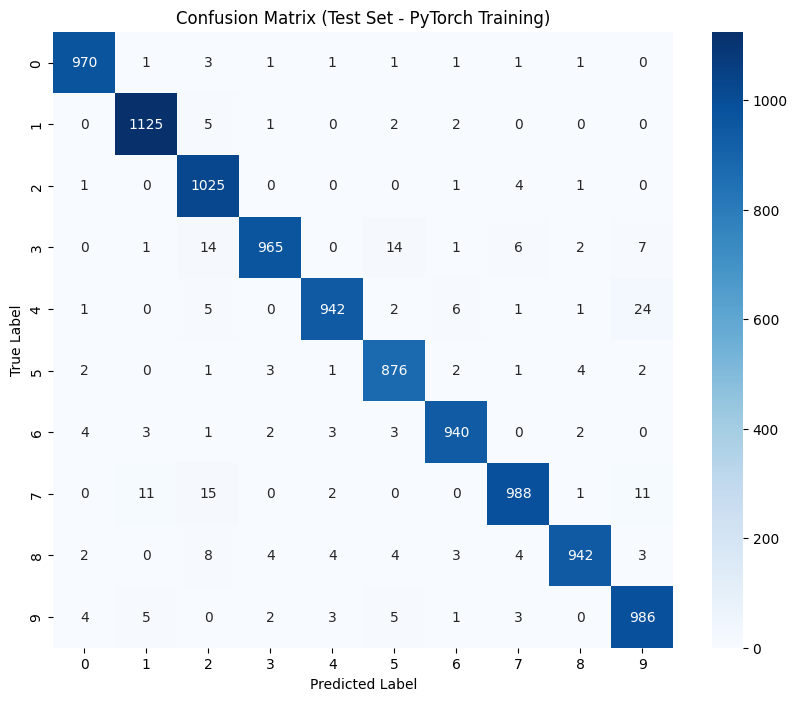


Evaluation complete.


In [ ]:
print("\n--- Evaluating Model on Test Set ---")
model.eval()
all_preds = []
all_labels = []

# No need to track gradients during evaluation
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images) # Forward pass

        # Max k calculation: value, index
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        # Store predictions and labels for detailed metrics
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate overall test accuracy
test_acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network on the {len(test_dataset)} test images: {test_acc:.2f} %')

# --- Detailed Evaluation Metrics (using sklearn) ---
print("\n--- Detailed Evaluation Metrics ---")
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(NUM_CLASSES)])
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Overall Test Accuracy (sklearn): {accuracy:.4f}")
print("\nClassification Report:")
print(report)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set - PyTorch Training)')
plt.show()

print("\nEvaluation complete.")

# Unlearn Configuration

In [ ]:
CLASS_TO_UNLEARN = 6
NUM_CLASSES = 10
OBFUSCATION_METHOD = 'label_randomization' # Options: 'label_randomization', 'add_noise', 'replace_with_noise'
NOISE_FACTOR = 0.6 # Used if OBFUSCATION_METHOD is 'add_noise'
FINETUNE_EPOCHS = 5
FINETUNE_LR = 1e-5 # Use a low learning rate for fine-tuning
BATCH_SIZE = 64

# Device Configuration

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Load Pre-trained Model

In [ ]:
print("Loading pre-trained model (or initializing placeholder)...")
model1 = SimpleMLP(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES).to(device)
model1.load_state_dict(torch.load('mnist_mlp_pytorch.pth', map_location=device))
print("Model loaded (or placeholder initialized).")
print(model1)

Loading pre-trained model (or initializing placeholder)...
Model loaded (or placeholder initialized).
SimpleMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=128, out_features=10, bias=True)
)


# Data Pre-Processing

In [ ]:
print("Loading MNIST data...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load original training data
train_dataset_full = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Original training samples: {len(train_dataset_full)}")
print(f"Test samples: {len(test_dataset)}")

Loading MNIST data...
Original training samples: 60000
Test samples: 10000


# Data Obfuscation

In [ ]:
print(f"Identifying and obfuscating data for class {CLASS_TO_UNLEARN}...")

train_data_np = train_dataset_full.data.numpy()
train_targets_np = train_dataset_full.targets.numpy()

# Create copies to modify
train_data_unlearn_np = np.copy(train_data_np)
train_targets_unlearn_np = np.copy(train_targets_np)

# Find indices of the class to unlearn
unlearn_indices = np.where(train_targets_np == CLASS_TO_UNLEARN)[0]
print(f"Found {len(unlearn_indices)} samples of class {CLASS_TO_UNLEARN} in the training set.")

if len(unlearn_indices) == 0:
    print(f"Warning: No samples found for class {CLASS_TO_UNLEARN}. Cannot perform unlearning.")
else:
    # Apply obfuscation to the numpy arrays
    if OBFUSCATION_METHOD == 'label_randomization':
        print("Applying label randomization...")
        for idx in unlearn_indices:
            original_label = train_targets_unlearn_np[idx]
            new_label = np.random.randint(0, NUM_CLASSES)
            while new_label == original_label:
                new_label = np.random.randint(0, NUM_CLASSES)
            train_targets_unlearn_np[idx] = new_label
        print(f"Labels for class {CLASS_TO_UNLEARN} randomized.")

    elif OBFUSCATION_METHOD == 'add_noise':
        print(f"Adding noise (factor: {NOISE_FACTOR})...")
        # Note: Adding noise *before* normalization is often preferred
        noise = np.random.normal(loc=0.0, scale=NOISE_FACTOR * 255, size=train_data_unlearn_np[unlearn_indices].shape)
        train_data_unlearn_np[unlearn_indices] = np.clip(train_data_unlearn_np[unlearn_indices].astype(np.float32) + noise, 0., 255.).astype(np.uint8)
        print(f"Noise added to images of class {CLASS_TO_UNLEARN}.")
        # Optionally randomize labels too
        # for idx in unlearn_indices: train_targets_unlearn_np[idx] = np.random.randint(0, NUM_CLASSES)


    elif OBFUSCATION_METHOD == 'replace_with_noise':
        print("Replacing images with random noise...")
        # Replace images with pure random noise (uint8 range)
        train_data_unlearn_np[unlearn_indices] = np.random.randint(0, 256, size=train_data_unlearn_np[unlearn_indices].shape, dtype=np.uint8)
        # Assign random labels
        for idx in unlearn_indices:
             train_targets_unlearn_np[idx] = np.random.randint(0, NUM_CLASSES)
        print(f"Images of class {CLASS_TO_UNLEARN} replaced with noise and labels randomized.")

    else:
        print(f"Error: Unknown OBFUSCATION_METHOD '{OBFUSCATION_METHOD}'")
        exit()

Identifying and obfuscating data for class 6...
Found 5918 samples of class 6 in the training set.
Applying label randomization...
Labels for class 6 randomized.


# Unlearning Dataset and DataLoader

In [ ]:
print("Creating unlearning dataset and dataloader...")

train_data_unlearn_tensor = torch.stack([transform(img) for img in train_data_unlearn_np])
train_targets_unlearn_tensor = torch.from_numpy(train_targets_unlearn_np).long()

# Create a new TensorDataset with the modified data
unlearn_dataset = TensorDataset(train_data_unlearn_tensor, train_targets_unlearn_tensor)
unlearn_loader = DataLoader(unlearn_dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Unlearning DataLoader created.")

Creating unlearning dataset and dataloader...
Unlearning DataLoader created.


# Fine-Tune Model

In [ ]:
print("Starting fine-tuning process...")

criterion = nn.CrossEntropyLoss()
# Use a low learning rate for the optimizer during fine-tuning
optimizer = optim.Adam(model1.parameters(), lr=FINETUNE_LR)

model1.train() # Set model to training mode

for epoch in range(FINETUNE_EPOCHS):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for i, (inputs, labels) in enumerate(unlearn_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model1(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    print(f'Fine-tuning Epoch [{epoch+1}/{FINETUNE_EPOCHS}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

print("Fine-tuning complete.")
# Save the unlearned model
torch.save(model1.state_dict(), 'mnist_mlp_model_unlearned_pytorch.pth')
print("Unlearned model saved.")

Starting fine-tuning process...
Fine-tuning Epoch [1/5], Loss: 1.0843, Accuracy: 0.8928
Fine-tuning Epoch [2/5], Loss: 0.5633, Accuracy: 0.8978
Fine-tuning Epoch [3/5], Loss: 0.4815, Accuracy: 0.9003
Fine-tuning Epoch [4/5], Loss: 0.4426, Accuracy: 0.9009
Fine-tuning Epoch [5/5], Loss: 0.4175, Accuracy: 0.9014
Fine-tuning complete.
Unlearned model saved.


# Model Evaluation (Unlearned Model)


--- Evaluating Unlearned Model ---
Overall Test Accuracy: 0.8855

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       980
           1       0.91      0.99      0.95      1135
           2       0.88      0.98      0.92      1032
           3       0.88      0.98      0.93      1010
           4       0.89      0.97      0.93       982
           5       0.89      0.97      0.93       892
           6       1.00      0.02      0.03       958
           7       0.91      0.98      0.94      1028
           8       0.87      0.97      0.92       974
           9       0.86      0.98      0.92      1009

    accuracy                           0.89     10000
   macro avg       0.90      0.88      0.84     10000
weighted avg       0.90      0.89      0.84     10000


Accuracy specifically for class 6: 0.0157
(Expected to be low if unlearning was successful)


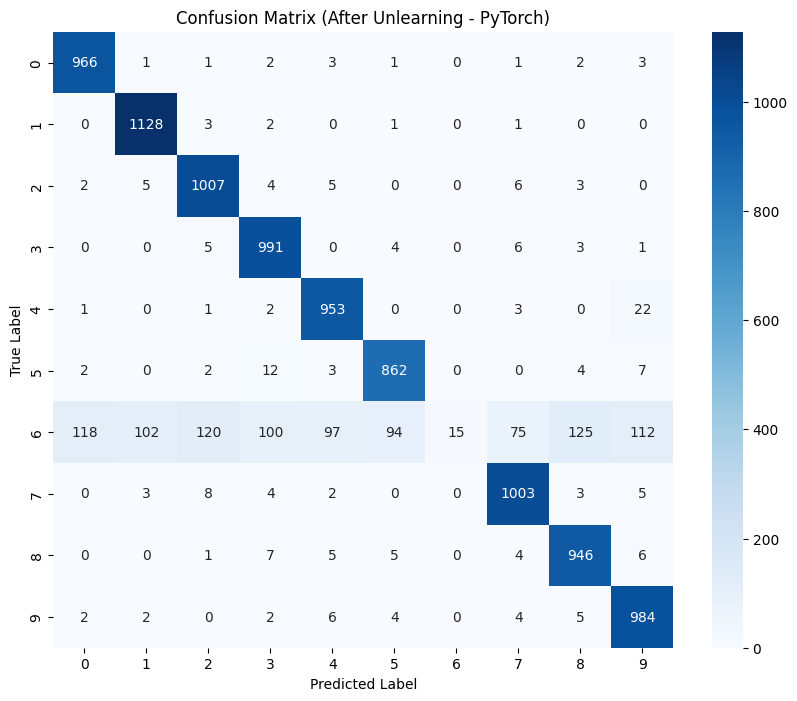


Evaluation complete. Check the classification report and confusion matrix.
Pay attention to the row/column corresponding to class 6.


In [ ]:
print("\n--- Evaluating Unlearned Model ---")

model1.eval() # Set model to evaluation mode
all_preds = []
all_labels = []
with torch.no_grad(): # Disable gradient calculation for evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model1(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy()) # Move predictions to CPU and store
        all_labels.extend(labels.cpu().numpy())   # Move labels to CPU and store

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate overall metrics using sklearn
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(NUM_CLASSES)])
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Overall Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

# Analyze performance specifically for the unlearned class
class_7_indices_test = np.where(all_labels == CLASS_TO_UNLEARN)[0]
if len(class_7_indices_test) > 0:
    y_test_class_7 = all_labels[class_7_indices_test]
    y_pred_class_7 = all_preds[class_7_indices_test]
    accuracy_class_7 = accuracy_score(y_test_class_7, y_pred_class_7)
    print(f"\nAccuracy specifically for class {CLASS_TO_UNLEARN}: {accuracy_class_7:.4f}")
    print(f"(Expected to be low if unlearning was successful)")
else:
    print(f"\nNo samples of class {CLASS_TO_UNLEARN} found in the test set for specific evaluation.")


# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (After Unlearning - PyTorch)')
plt.show()

print("\nEvaluation complete. Check the classification report and confusion matrix.")
print(f"Pay attention to the row/column corresponding to class {CLASS_TO_UNLEARN}.")